## Behavioral cloning

The goal of this project is to train the model to drive the car like human would do.

Quick notes:





In [1]:
from keras.utils.visualize_util import plot
from sklearn.cross_validation import train_test_split
import matplotlib.pylab as plt
import cv2

import app.training as t
import app.config as cfg
import app.model  as m
import app.transform as tr

%matplotlib inline

Using TensorFlow backend.
/home/tadas/anaconda3/envs/tf/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
log = t.load_data()
steering_angles = log.values[:,3]
print('Number of driving log records: {}'.format(log.shape[0]))

Number of driving log records: 8036


We don't have much records so we will have to be creative to augment training set to produce more images.

Let's do quick analysis what we have here and see what is the distribution of steering angles we have in our dataset

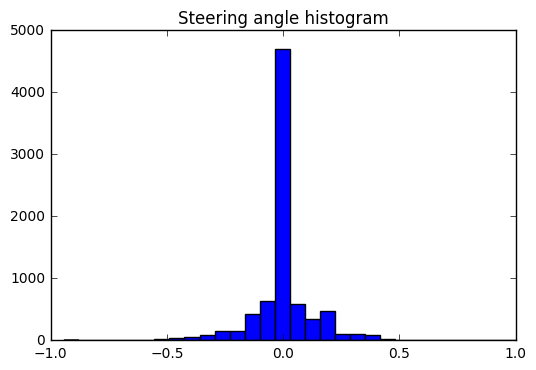

In [3]:
_ = plt.hist(steering_angles, bins=30)
plt.title('Steering angle histogram')

Our dataset contains lot of pictures where steering angle is around 0. That might hurt the model, therefore some technique should be in place to take this into account and balance training data

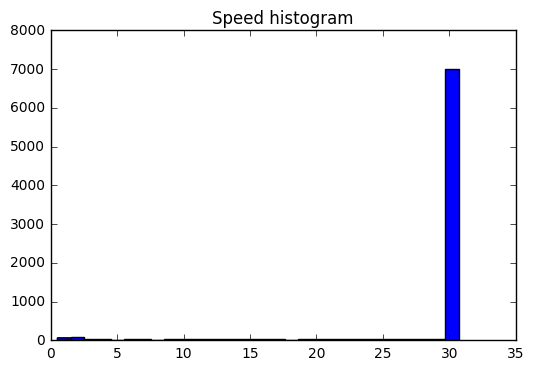

In [4]:
_ = plt.hist(log.values[:,6], bins=30)
plt.title('Speed histogram')

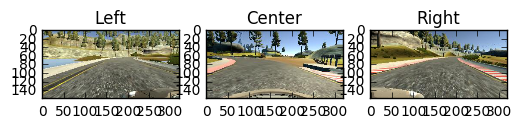

In [5]:
left = t.load_image('images/left.jpg')
right = t.load_image('images/right.jpg')
center = t.load_image('images/center.jpg')

plt.subplot(1, 3, 1)
plt.title('Left')
plt.imshow(left)

plt.subplot(1,3, 2)
plt.title('Center')
plt.imshow(center)

plt.subplot(1, 3, 3)
plt.title('Right')
plt.imshow(right)

## Left / Right use of cameras

Since we don't have much training data we will have to make more from what we have. First thing is to decide how we can leverage all three images (left, right and center). The left and right images can play a big role in recovery situations. But we need to shift the camera slightly. I've done some testing and it looks like good value to use is:

In [6]:
print('Camera shift for (left/right): {}/{}'.format(cfg.SHIFT_CAMERA, cfg.SHIFT_CAMERA*(-1)))

Camera shift for (left/right): 0.25/-0.25


Setting this number too high will end up too much "zig-zagging" with high training accuracy but will work better on sharp corners, setting this number too low will make car go more smoothly, however it will perform badly on the sharp corners.

## Flipping images

Another useful technique to generate additional data is to flip image and flip steering angle. That will add additional 2x images

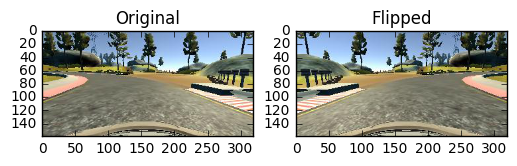

In [7]:
plt.subplot(1,2,1)
plt.imshow(center)
plt.title('Original')

plt.subplot(1,2,2)
plt.title('Flipped')
flipped = tr.flip(center,1)[0]
plt.imshow( flipped )

## Image augmentation

To produce more training data I have experimented with different techniques to generate more images. Some of the techniques I tried is:

* Zooming / Rotating images
* Shifting images left / right and up / down
* Changing brightness
* Blurring
* Dropping shadows

It turned out that shifting images is very useful. But one question remains do we have to change steering angle for shifted image to left or right. After some testing and reading other people suggestions I decided that it benefits if I also change steering angle if I move image to either left or right. Blurring made it worse. Dropping shadows didn't help either.

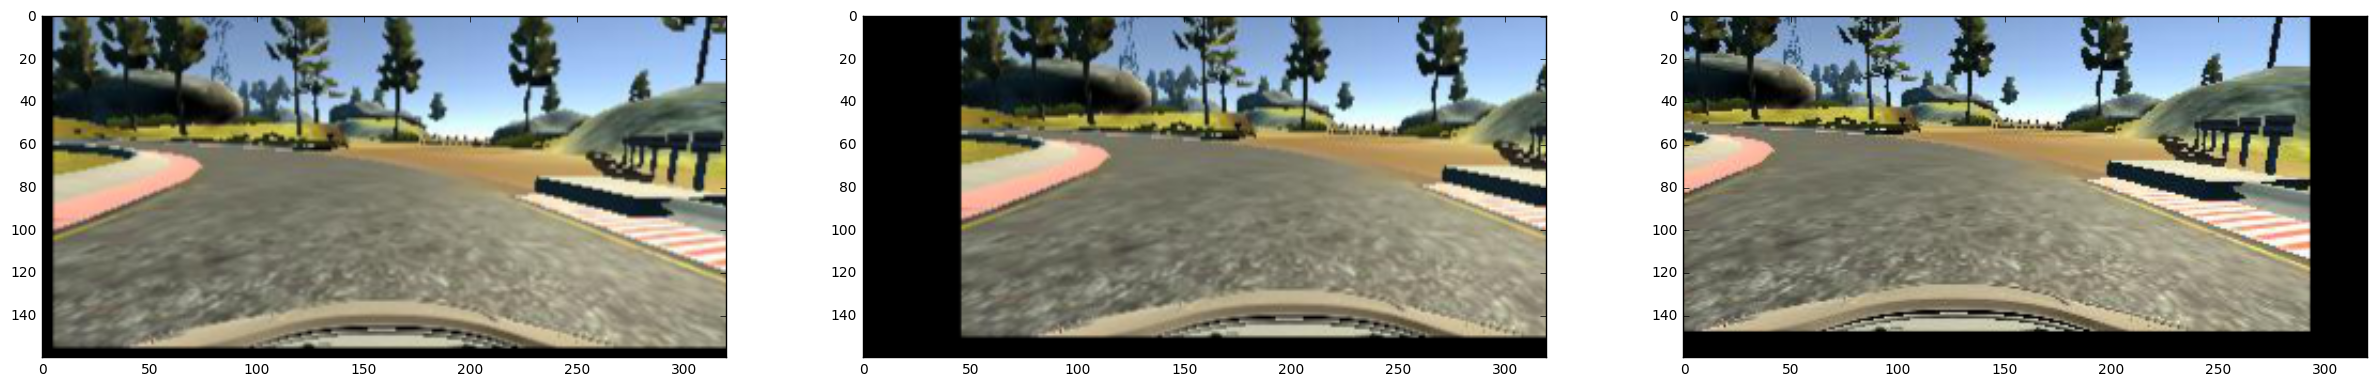

In [8]:
plt.subplots(figsize=(30, 10))
for i in range(3):
    plt.subplot(1,3,i+1)
    shifted = tr.augment_shift_image(center, 0)
    plt.imshow(shifted[0])

### Changing brightness

Changing brightness helps to deal with shadows especially for track 2. Here is an example

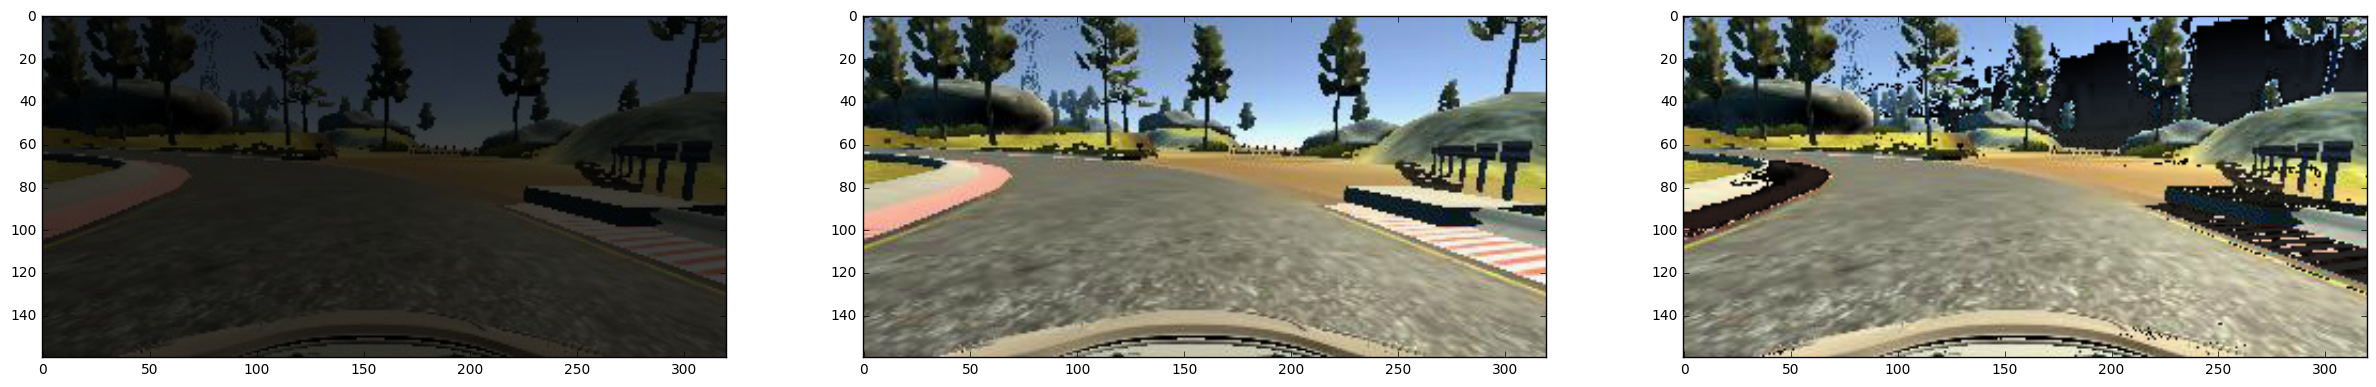

In [9]:
plt.subplots(figsize=(30, 10))
for i in range(3):
    plt.subplot(1,3,i+1)
    coloured = tr.augment_colours(center)
    plt.imshow(coloured)

### Final images after all augmentations has been applied

Here is some example of what we get for training after all augmentations has been applied

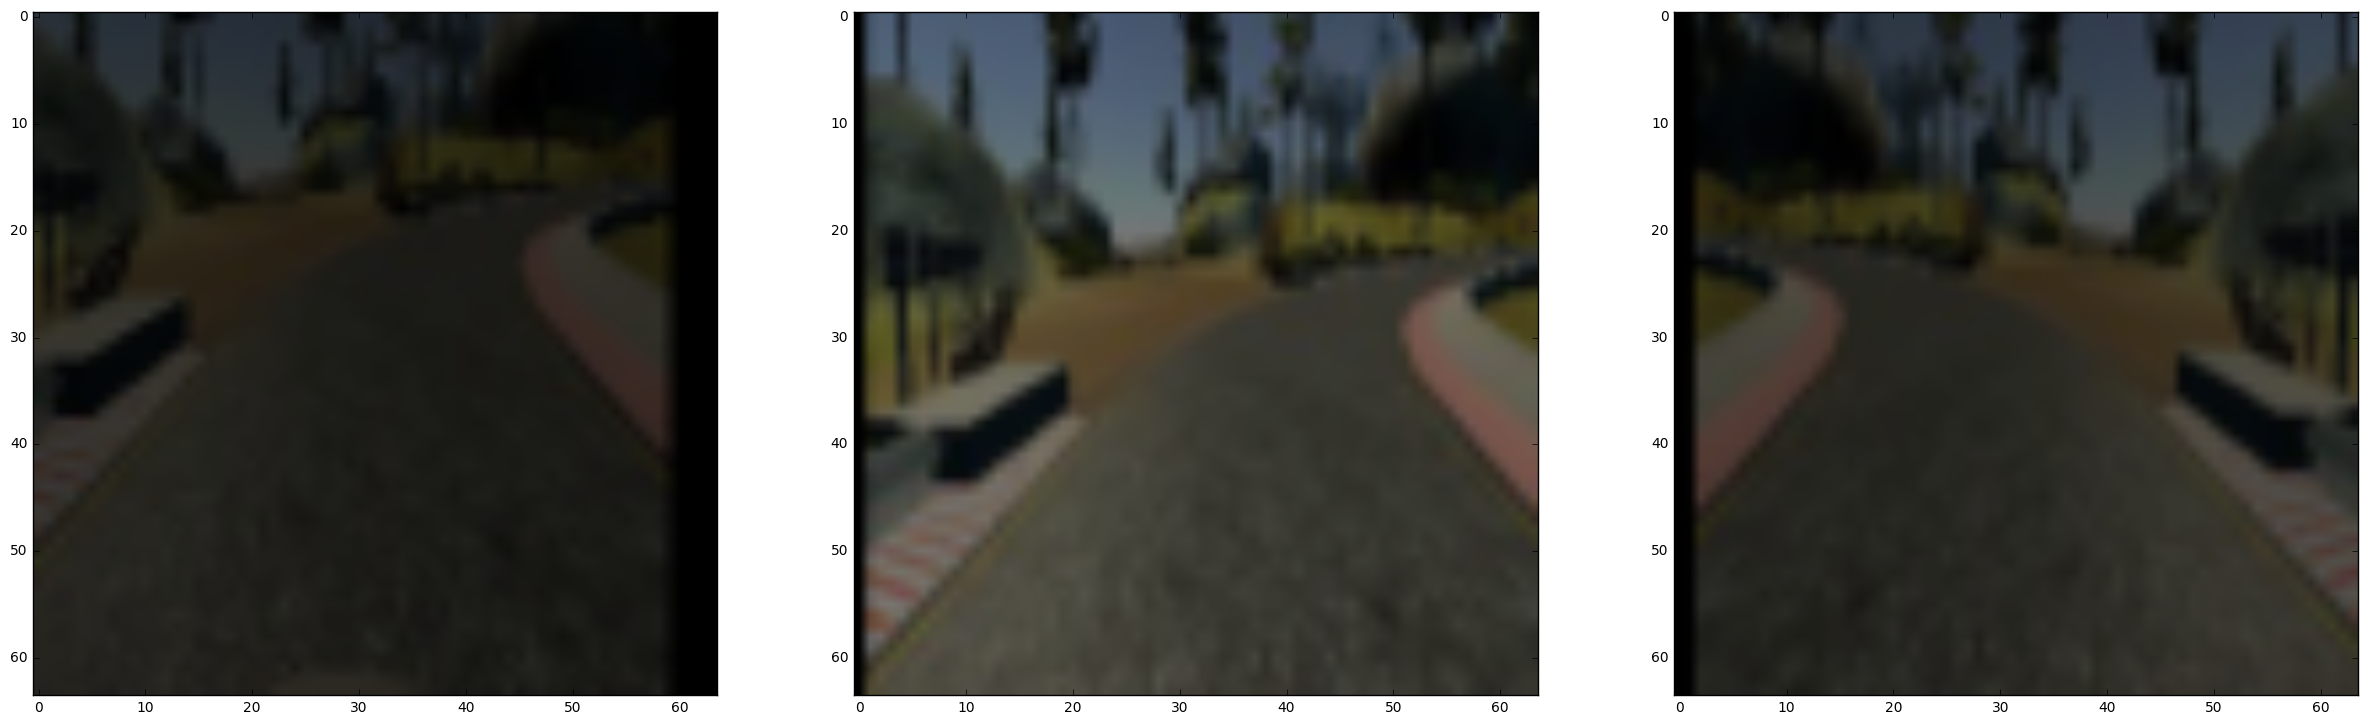

In [10]:
plt.subplots(figsize=(30, 10))
for i in range(3):
    plt.subplot(1,3,i+1)
    x = tr.augment_image(center, 0)
    plt.imshow(x[0])

### Cropping and resizing

There are additional objects like trees which we don't need them, also we don't need bottoom of the image. The are interested only in the road. Also, image size is big, thus resizing will reduce the training size and improve accuracy. But keeping all x axis is useful since it represents all road

Resize to (64, 64)


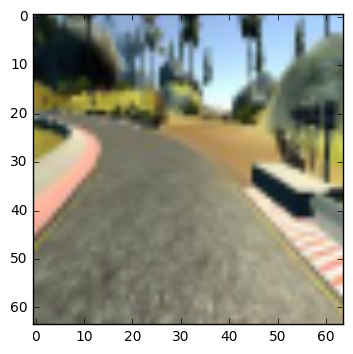

In [11]:
print('Resize to {}'.format(cfg.IMG_RESIZE_SHAPE))
img = tr.fix_image(center)
plt.imshow(img)

#### Resize and interpolation

Somehow it is **very** important to use proper interpolation technique while resizing. I wasted lot of time testing my model without much luck because I did not specify interpolation technique. Actually, the difference is **huge**. Without specifying the interpolation the car was hitting almost every corner and fail to reach the finish line but applying interpolation made the car go smoothly. So after some testing I found out that *INTER_AREA* works best

## Model

I have experimented with different types of pre-trained models like *VGG16, Inception* etc. Even if I don't train pre-trained layers and only add extra couple of layers and train only them it takes ages! to run on CPU. Without GPU it's hard to do trial-error experiments. So I ended up using *comma.ai* simple model which works very well. In the end I've notice that simple model works even better than more complicated but the key element in this assignment is having good training data.

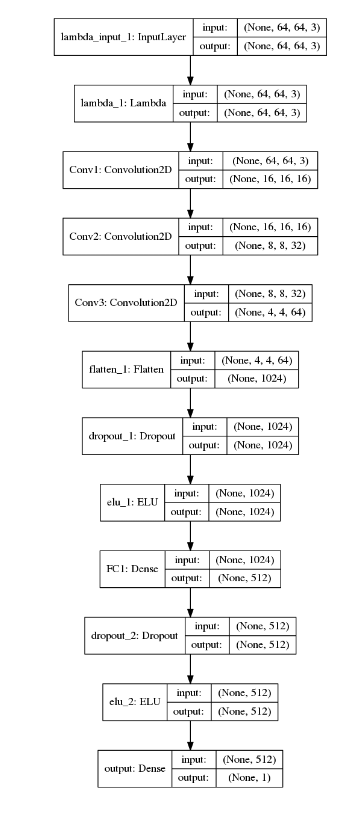

In [12]:
model = m.get_model()
plot(model, to_file='images/model_chart.png', show_shapes=True)
img = cv2.imread('images/model_chart.png')
plt.subplots(figsize=(5,10))
plt.subplot(111)
plt.axis('off')
plt.imshow(img)

<pre>
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to
====================================================================================================
lambda_1 (Lambda)                (None, 32, 32, 3)     0           lambda_input_1[0][0]
____________________________________________________________________________________________________
Conv1 (Convolution2D)            (None, 8, 8, 16)      3088        lambda_1[0][0]
____________________________________________________________________________________________________
Conv2 (Convolution2D)            (None, 4, 4, 32)      12832       Conv1[0][0]
____________________________________________________________________________________________________
Conv3 (Convolution2D)            (None, 2, 2, 64)      51264       Conv2[0][0]
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 256)           0           Conv3[0][0]
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 256)           0           flatten_1[0][0]
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 256)           0           dropout_1[0][0]
____________________________________________________________________________________________________
FC1 (Dense)                      (None, 512)           131584      elu_1[0][0]
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 512)           0           FC1[0][0]
____________________________________________________________________________________________________
elu_2 (ELU)                      (None, 512)           0           dropout_2[0][0]
____________________________________________________________________________________________________
output (Dense)                   (None, 1)             513         elu_2[0][0]
====================================================================================================
</pre>

After experimenting I found out that relying on validation loss is not very effective. For example if using left and right cameras without changing steering angle would produce much smaller validation loss, however when testing on real track it would perform poorly

### Fixing the balance of steering angles in the training set

As we saw in the histogram we do have a lot of images where steering angle is 0 or very close to zero. Since it would affect the model we are going to reduce the probability such as if steering angle is close to 0 (specified by PROB_RANGE parameter) randomly generate the uniform number and if the number is close to 1 (specified by THRESHOLD parameter) then image will be re-augmented and will go other this loop again. If it satisfies the condition then it will be added to the batch training set

In [13]:
print('THRESHOLD: {}\nPROB_RANGE: {}'.format(cfg.THRESHOLD, cfg.PROB_RANGE))

THRESHOLD: 0.85
PROB_RANGE: 0.08


### Splitting training data and testing data

We don't have much training data so keeping the validation data sample should be small since the best validation is actually running on the real track. So, only 10% will be used for testing data

In [14]:
train, validation = train_test_split(log, test_size=0.10)
print ('Training: {}\nTesting: {}'.format(train.shape[0], validation.shape[0]))

Training: 7232
Testing: 804


### Training parameter

After performing some tests I found that the following parameters works best

In [15]:
print('Batch size: {}'.format(cfg.BATCH_SIZE))
print('Learning rate: {}'.format(cfg.LEARNING_RATE))
print('Number of Epoch: {}'.format(cfg.NB_EPOCH))

Batch size: 128
Learning rate: 0.0001
Number of Epoch: 8


### Training results

The measure for accuracy I use MSE and final results was around ~0.04. As I learned that actually if accuracy is dropping lower than 0.004 it probably wont work well while running simulator. I guess we can't get low accuracy because of shifting images to left or right and adjusting steering wheel accordingly also we change steering angle when using left or right cameras.

## Speed control

Since model works good when speed is around 15mph, the code will keep speed close to specified maximum by either increasing or decreasing throttle. It is most useful whilst driving on track 2. The maximum speed can be passed by arguments.

## Conclusion

This project was challenging one it took me lot of time while I reached satisfactory results. Also testing pre-trained models was a pain since I don't have GPU and running on CPU takes around ~8h, therefore I decided to use something lightweight.
Finally the model completed both track (with tweaking parameters). It is actually enough 3 epoch and around ~20k training data to train the model which can complete track 1. And it can be done on CPU fairy quickly but what I learned in this project that training data is the answer to all problems. The architecture of the model isn't that important as having good training data !

### Acknowledgment

I have used many ideas from blog written by Vivek Yadav. It was a great help when I was stuck.